In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.spatial.distance import pdist, squareform

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [2]:
df = pd.read_excel("./data/data_pdp.xlsx")
print(f"Dimensions: {df.shape}")
print(df.head())

Dimensions: (10000, 3)
         X1        X2          Y
0 -0.836354  4.520502 -19.868094
1  0.402008  3.252834 -10.465985
2 -0.249214  3.610425 -12.914992
3 -0.625717  4.588770 -20.678396
4 -0.989995  4.893924 -22.994044


In [3]:
def pearson_correlation(x: np.ndarray, y: np.ndarray) -> float:
    """Compute the Pearson correlation coefficient between two arrays."""
    return np.corrcoef(x, y)[0, 1]


def distance_correlation(x: np.ndarray, y: np.ndarray) -> float:
    """Compute the Distance Correlation between two arrays."""
    n = len(x)
    x = np.array(x).reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)

    a = squareform(pdist(x, "euclidean"))
    b = squareform(pdist(y, "euclidean"))

    a_row_mean = a.mean(axis=1, keepdims=True)
    a_col_mean = a.mean(axis=0, keepdims=True)
    a_grand_mean = a.mean()
    A = a - a_row_mean - a_col_mean + a_grand_mean

    b_row_mean = b.mean(axis=1, keepdims=True)
    b_col_mean = b.mean(axis=0, keepdims=True)
    b_grand_mean = b.mean()
    B = b - b_row_mean - b_col_mean + b_grand_mean

    dCov_squared = (A * B).sum() / (n * n)
    dVar_X = (A * A).sum() / (n * n)
    dVar_Y = (B * B).sum() / (n * n)

    if dVar_X <= 0 or dVar_Y <= 0:
        return 0.0

    return np.sqrt(dCov_squared) / np.sqrt(np.sqrt(dVar_X) * np.sqrt(dVar_Y))


def mic_approx(x: np.ndarray, y: np.ndarray, bins: int = 15) -> float:
    """Compute an approximation of the Maximal Information Coefficient (MIC) between two arrays."""
    c_xy, _, _ = np.histogram2d(x, y, bins=bins)
    pxy = c_xy / float(np.sum(c_xy))
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)

    px_py = px[:, None] * py[None, :]

    nzs = pxy > 0
    mi = np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

    mic = mi / np.log(min(bins, bins))
    return min(mic, 1.0)  # S'assurer que MIC <= 1


def xi_correlation(x: np.ndarray, y: np.ndarray) -> float:
    """Compute the Xi correlation between two arrays."""
    n = len(x)
    x = np.array(x)
    y = np.array(y)

    order = np.argsort(x)
    y_ordered = y[order]

    ranks = stats.rankdata(y_ordered)

    sum_diff = np.sum(np.abs(np.diff(ranks)))

    return 1 - (3 * sum_diff) / (n**2 - 1)


In [4]:
X1 = df["X1"].to_numpy()
X2 = df["X2"].to_numpy()
Y = df["Y"].to_numpy()

pearson_Y_X1 = pearson_correlation(X1, Y)
dcor_Y_X1 = distance_correlation(X1, Y)
mic_Y_X1 = mic_approx(X1, Y)
xi_Y_X1 = xi_correlation(X1, Y)

print("\n=== Y vs X1 ===")
print(f"Pearson: {pearson_Y_X1:.4f}")
print(f"dCOR:    {dcor_Y_X1:.4f}")
print(f"MIC:     {mic_Y_X1:.4f}")
print(f"ξn:      {xi_Y_X1:.4f}")

# Pour Y vs X2
pearson_Y_X2 = pearson_correlation(X2, Y)
dcor_Y_X2 = distance_correlation(X2, Y)
mic_Y_X2 = mic_approx(X2, Y)
xi_Y_X2 = xi_correlation(X2, Y)

print("\n=== Y vs X2 ===")
print(f"Pearson: {pearson_Y_X2:.4f}")
print(f"dCOR:    {dcor_Y_X2:.4f}")
print(f"MIC:     {mic_Y_X2:.4f}")
print(f"ξn:      {xi_Y_X2:.4f}")


=== Y vs X1 ===
Pearson: -0.0008
dCOR:    0.0245
MIC:     0.0037
ξn:      0.0047

=== Y vs X2 ===
Pearson: -0.9675
dCOR:    0.9812
MIC:     0.7285
ξn:      0.9327


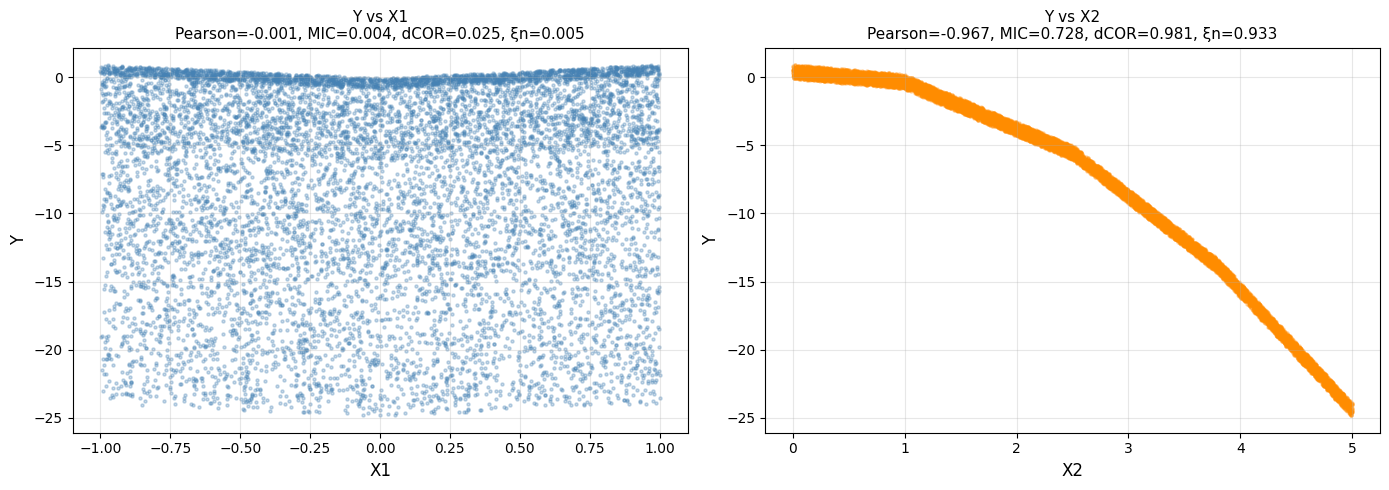

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.scatter(X1, Y, alpha=0.3, s=5, c="steelblue")
ax1.set_xlabel("X1", fontsize=12)
ax1.set_ylabel("Y", fontsize=12)
ax1.set_title(
    f"Y vs X1\n"
    f"Pearson={pearson_Y_X1:.3f}, MIC={mic_Y_X1:.3f}, dCOR={dcor_Y_X1:.3f}, ξn={xi_Y_X1:.3f}",
    fontsize=11,
)
ax1.grid(visible=True, alpha=0.3)

# Graphique Y vs X2
ax2 = axes[1]
ax2.scatter(X2, Y, alpha=0.3, s=5, c="darkorange")
ax2.set_xlabel("X2", fontsize=12)
ax2.set_ylabel("Y", fontsize=12)
ax2.set_title(
    f"Y vs X2\n"
    f"Pearson={pearson_Y_X2:.3f}, MIC={mic_Y_X2:.3f}, dCOR={dcor_Y_X2:.3f}, ξn={xi_Y_X2:.3f}",
    fontsize=11,
)
ax2.grid(visible=True, alpha=0.3)

plt.tight_layout()
plt.savefig("question1_correlation_plots.png", dpi=150, bbox_inches="tight")
plt.show()

In [6]:
def generator_function(X1: np.ndarray, X2: np.ndarray) -> np.ndarray:
    """Generate Y values based on piecewise linear functions of X1 and X2."""
    res = -1.9492061
    res += np.maximum(0, -0.001853 - X1) * 1.0004139
    res += np.maximum(0, X1 - (-0.001853)) * 1.0002827
    res += np.maximum(0, X2 - 0.985433) * -2.7023554
    res += np.maximum(0, 2.4996 - X2) * 0.7443016
    res += np.maximum(0, X2 - 2.4996) * -3.7085839
    res += np.maximum(0, X2 - 3.80119) * -2.3717626
    return res


def calculate_pdf(feature_name: str, grid_values: np.ndarray, data: pd.DataFrame) -> np.ndarray:
    """Calculate the Partial Dependence Function (PDF) for a given feature."""
    pdf_values = []

    for val in grid_values:
        temp_X1 = data["X1"].to_numpy().copy()
        temp_X2 = data["X2"].to_numpy().copy()

        if feature_name == "X1":
            temp_X1[:] = val
        else:
            temp_X2[:] = val

        Y_pred = generator_function(temp_X1, temp_X2)

        avg_prediction = np.mean(Y_pred)
        pdf_values.append(avg_prediction)

    return np.array(pdf_values)

In [7]:
x1_min, x1_max = df["X1"].min(), df["X1"].max()
x2_min, x2_max = df["X2"].min(), df["X2"].max()

grid_X1 = np.arange(np.floor(x1_min * 10) / 10, np.ceil(x1_max * 10) / 10 + 0.1, 0.1)
grid_X2 = np.arange(np.floor(x2_min * 4) / 4, np.ceil(x2_max * 4) / 4 + 0.25, 0.25)

pdf_X1 = calculate_pdf("X1", grid_X1, df)

pdf_X2 = calculate_pdf("X2", grid_X2, df)

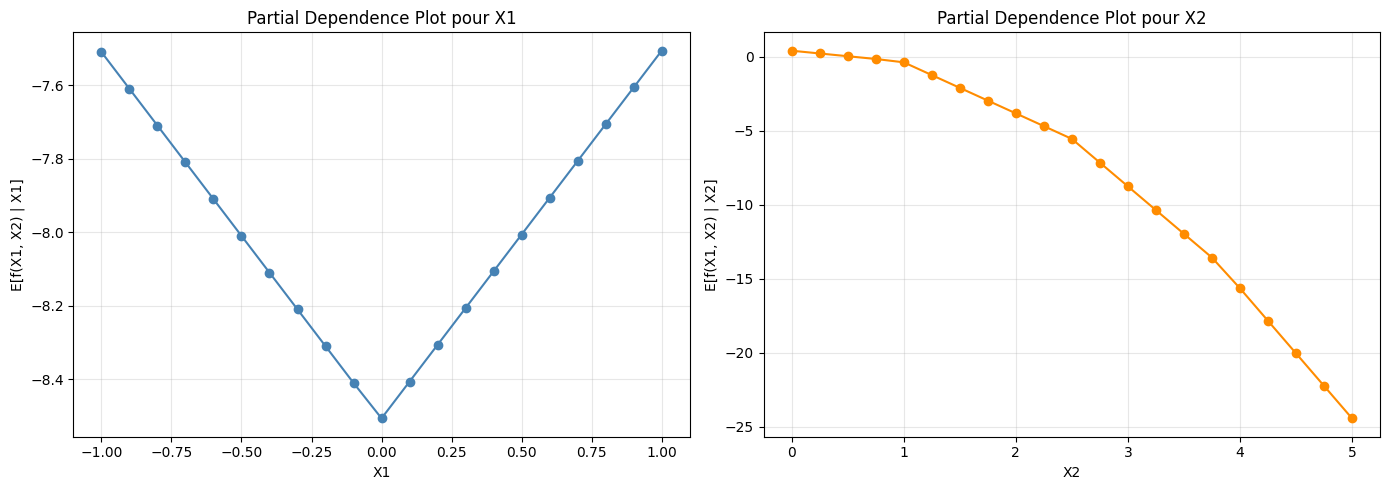

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.plot(grid_X1, pdf_X1, "o-", color="steelblue", label="PDF(X1)")
ax1.set_xlabel("X1")
ax1.set_ylabel("E[f(X1, X2) | X1]")
ax1.set_title("Partial Dependence Plot pour X1")
ax1.grid(visible=True, alpha=0.3)

ax2 = axes[1]
ax2.plot(grid_X2, pdf_X2, "o-", color="darkorange", label="PDF(X2)")
ax2.set_xlabel("X2")
ax2.set_ylabel("E[f(X1, X2) | X2]")
ax2.set_title("Partial Dependence Plot pour X2")
ax2.grid(visible=True, alpha=0.3)

plt.tight_layout()
plt.savefig("question2_pdp_plots.png")
plt.show()

Modèle X1 (Linéaire) : y = 0.0026x + -7.9838
Qualité (R2) : 0.0000

Modèle X2 (Quadratique) : y = -0.9883x^2 + -0.0539x + 0.3815
Qualité (R2) : 0.9996


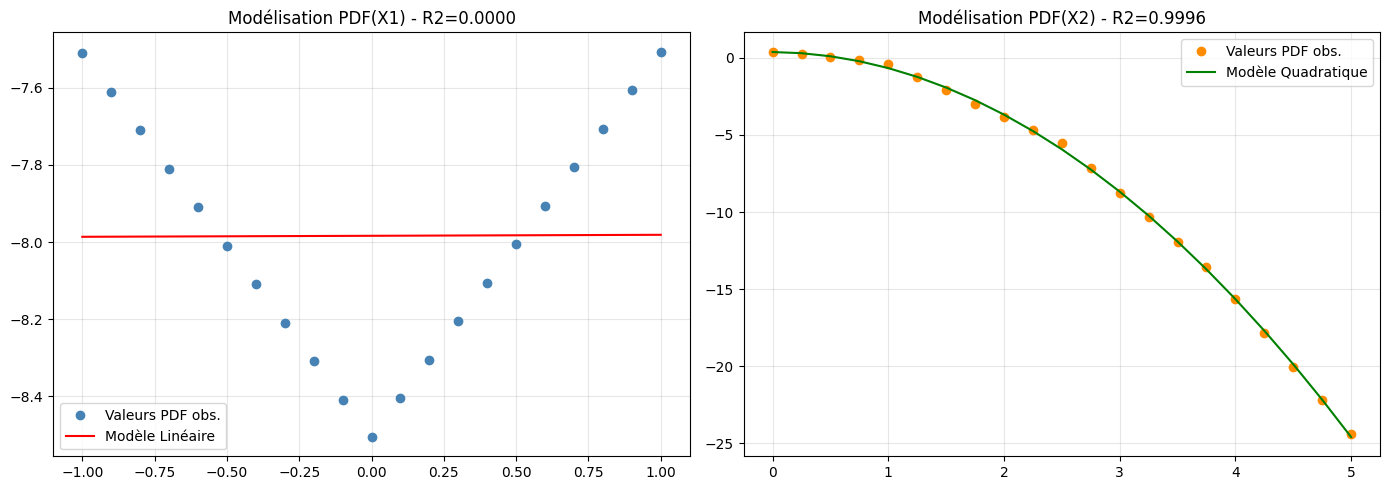

In [9]:
# Modélisation X1 : Polynôme degré 1 (Linéaire)
coefs_X1 = np.polyfit(grid_X1, pdf_X1, 1)
f_X1_poly = np.poly1d(coefs_X1)
pdf_pred_X1 = f_X1_poly(grid_X1)
r2_X1 = r2_score(pdf_X1, pdf_pred_X1)

# Modélisation X2 : Polynôme degré 2 (Quadratique)
coefs_X2 = np.polyfit(grid_X2, pdf_X2, 2)
f_X2_poly = np.poly1d(coefs_X2)
pdf_pred_X2 = f_X2_poly(grid_X2)
r2_X2 = r2_score(pdf_X2, pdf_pred_X2)

print(f"Modèle X1 (Linéaire) : y = {coefs_X1[0]:.4f}x + {coefs_X1[1]:.4f}")
print(f"Qualité (R2) : {r2_X1:.4f}")

print(
    f"\nModèle X2 (Quadratique) : y = {coefs_X2[0]:.4f}x^2 + {coefs_X2[1]:.4f}x + {coefs_X2[2]:.4f}",
)
print(f"Qualité (R2) : {r2_X2:.4f}")

# Affichage des résultats
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot X1
ax1 = axes[0]
ax1.plot(grid_X1, pdf_X1, "o", color="steelblue", label="Valeurs PDF obs.")
ax1.plot(grid_X1, pdf_pred_X1, "-", color="red", label="Modèle Linéaire")
ax1.set_title(f"Modélisation PDF(X1) - R2={r2_X1:.4f}")
ax1.legend()
ax1.grid(visible=True, alpha=0.3)

# Plot X2
ax2 = axes[1]
ax2.plot(grid_X2, pdf_X2, "o", color="darkorange", label="Valeurs PDF obs.")
ax2.plot(grid_X2, pdf_pred_X2, "-", color="green", label="Modèle Quadratique")
ax2.set_title(f"Modélisation PDF(X2) - R2={r2_X2:.4f}")
ax2.legend()
ax2.grid(visible=True, alpha=0.3)

plt.tight_layout()
plt.savefig("question3_model_plots.png")
plt.show()

In [10]:
# 1. Régression sur variables initiales (X1, X2)
X_init = df[["X1", "X2"]].to_numpy()
reg_init = LinearRegression().fit(X_init, Y)
y_pred_init = reg_init.predict(X_init)
r2_init = r2_score(Y, y_pred_init)

# 2. Transformation des variables avec nos modèles f(X1) et f(X2)
X1_trans = f_X1_poly(df["X1"].to_numpy())
X2_trans = f_X2_poly(df["X2"].to_numpy())
X_trans = np.column_stack((X1_trans, X2_trans))

# 3. Régression sur variables transformées
reg_trans = LinearRegression().fit(X_trans, Y)
y_pred_trans = reg_trans.predict(X_trans)
r2_trans = r2_score(Y, y_pred_trans)

# Affichage des résultats comparatifs
print(f"Modèle Initial    (Y ~ X1 + X2)       : R2 = {r2_init:.6f}")
print(f"Modèle Transformé (Y ~ f(X1) + f(X2)) : R2 = {r2_trans:.6f}")

# Analyse des coefficients
print("\n--- Modèle Initial ---")
print(
    f"Coefs: X1={reg_init.coef_[0]:.4f}, X2={reg_init.coef_[1]:.4f}, Intercept={reg_init.intercept_:.4f}",
)

print("\n--- Modèle Transformé ---")
print(
    f"Coefs: f(X1)={reg_trans.coef_[0]:.4f}, f(X2)={reg_trans.coef_[1]:.4f}, Intercept={reg_trans.intercept_:.4f}",
)

Modèle Initial    (Y ~ X1 + X2)       : R2 = 0.935990
Modèle Transformé (Y ~ f(X1) + f(X2)) : R2 = 0.998194

--- Modèle Initial ---
Coefs: X1=-0.0273, X2=-4.9734, Intercept=4.4122

--- Modèle Transformé ---
Coefs: f(X1)=7.0490, f(X2)=1.0010, Intercept=56.2702


# Question 4 : Nouvelles Régressions et Comparaisons
Régresser Y sur f(X1) et f(X2). Comparer avec la régression initiale.


R2 Initiale    : 0.935990
R2 Transformée : 0.998194


/var/folders/tp/_ld5_pzs6nx6mv1pbjhq1l740000gn/T/ipykernel_6798/1452751939.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[0].boxplot([resid_init, resid_trans], labels=["Initiale", "Transformée"])


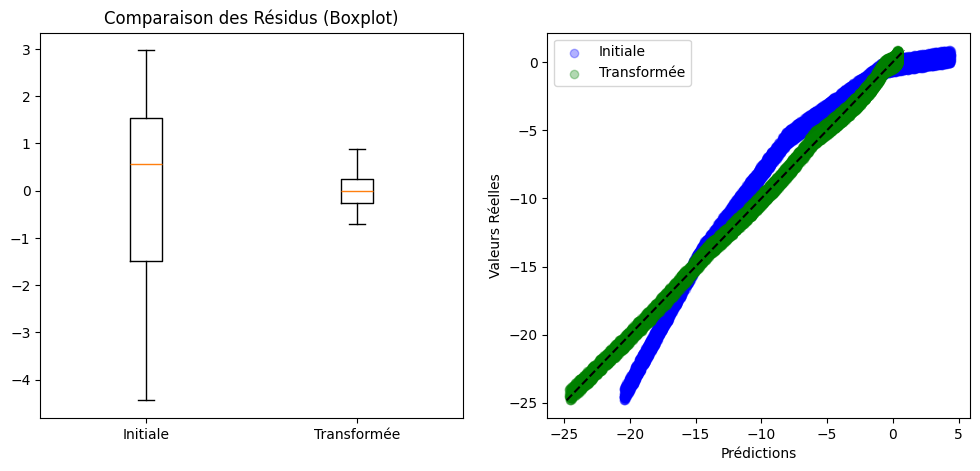

In [11]:
# 1. Régression Initiale (Y ~ X1 + X2)
X_init = df[["X1", "X2"]].to_numpy()
Y = df["Y"].to_numpy()
reg_init = LinearRegression().fit(X_init, Y)
y_pred_init = reg_init.predict(X_init)
r2_init = r2_score(Y, y_pred_init)

# 2. Préparation des variables transformées
X1_trans = f_X1_poly(df["X1"].to_numpy())
X2_trans = f_X2_poly(df["X2"].to_numpy())
X_trans = np.column_stack((X1_trans, X2_trans))

# 3. Régression Transformée (Y ~ f(X1) + f(X2))
reg_trans = LinearRegression().fit(X_trans, Y)
y_pred_trans = reg_trans.predict(X_trans)
r2_trans = r2_score(Y, y_pred_trans)

print(f"R2 Initiale    : {r2_init:.6f}")
print(f"R2 Transformée : {r2_trans:.6f}")

# Comparaison Résidus
resid_init = Y - y_pred_init
resid_trans = Y - y_pred_trans

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].boxplot([resid_init, resid_trans], labels=["Initiale", "Transformée"])
ax[0].set_title("Comparaison des Résidus (Boxplot)")

ax[1].scatter(y_pred_init, Y, alpha=0.3, label="Initiale", color="blue")
ax[1].scatter(y_pred_trans, Y, alpha=0.3, label="Transformée", color="green")
ax[1].plot([Y.min(), Y.max()], [Y.min(), Y.max()], "k--")
ax[1].set_xlabel("Prédictions")
ax[1].set_ylabel("Valeurs Réelles")
ax[1].legend()
plt.show()


# Question 5 : Développement Algébrique
Développer l'équation, simplifier les coefficients et évaluer.


In [12]:
# Récupération des coefficients
beta_0 = reg_trans.intercept_
beta_1 = reg_trans.coef_[0]
beta_2 = reg_trans.coef_[1]

# f(X1) = a1*X1 + b1
a1, b1 = coefs_X1

# f(X2) = a2*X2^2 + b2*X2 + c2
a2, b2, c2 = coefs_X2

# calcul algébrique des nouveaux coefficients combinés
# Y = C + A*X1 + B*X2 + D*X2^2  # noqa: ERA001
C_final = beta_0 + beta_1 * b1 + beta_2 * c2
A_final = beta_1 * a1
B_final = beta_2 * b2
D_final = beta_2 * a2

print("=== Coefficients ===")
print(f"Constante (C) : {C_final}")
print(f"X1 (A)        : {A_final}")
print(f"X2 (B)        : {B_final}")
print(f"X2^2 (D)      : {D_final}")

# Arrondi
C_rnd = np.round(C_final, 0)
A_rnd = np.round(A_final, 0)
B_rnd = np.round(B_final, 0)
D_rnd = np.round(D_final, 0)

print(f"Equation Simplifiée: Y = {C_rnd} + {A_rnd}*X1 + {B_rnd}*X2 + {D_rnd}*X2^2")

# Évaluation Modèle Simplifié
Y_simp = C_rnd + A_rnd * df["X1"] + B_rnd * df["X2"] + D_rnd * (df["X2"] ** 2)
r2_simp = r2_score(Y, Y_simp)
print(f"R2 Modèle Simplifié : {r2_simp:.6f}")


=== Coefficients ===
Constante (C) : 0.3747036487969149
X1 (A)        : 0.01820374059738573
X2 (B)        : -0.05394293499898463
X2^2 (D)      : -0.9892967399095874
Equation Simplifiée: Y = 0.0 + 0.0*X1 + -0.0*X2 + -1.0*X2^2
R2 Modèle Simplifié : 0.996241
